#Import Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import matplotlib.pyplot as plt
import requests
import os

#Preprocess Text

In [6]:
file_path = tf.keras.utils.get_file('Nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt' )

f = open(file_path, 'rb').read().decode(encoding='utf-8')

text = f.lower()
vocabulary = sorted(set(text))

char2idx = {u:i for i,u in enumerate(vocabulary)} #Dictionary that maps character to index
idx2char = np.array(vocabulary)                   #An array with vocabulary

text_as_int = np.array([char2idx[c] for c in text]) #Takes in text and returns as integers

seq_len = 100
ex_per_epochs = len(text) // (seq_len + 1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) #Makes text a tf dataset

for i in char_dataset.take(10):
    print(idx2char[i.numpy()])

p
r
e
f
a
c
e








In [7]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True) #Combines consecutive elements into batches

def split_input_target(chunk):
  '''Takes input and creates a target text'''
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

for i, t in dataset.take(1):
    print('Input: ', repr(''.join(idx2char[i.numpy()])))
    print('Target: ', repr(''.join(idx2char[t.numpy()])))
    
    
    
batch_size = 128
buffer_size = 10000

dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

dataset

Input:  'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all ph'
Target:  'reface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all phi'


<BatchDataset shapes: ((128, 100), (128, 100)), types: (tf.int64, tf.int64)>

In [8]:
vocab_size = len(vocabulary)

embedding_dim = 256

#Build, Compile, and Train Model

In [9]:
def build_model(vocab_size, embedding_dim, batch_size):
  '''
  Creates a RNN using stacked GRU layers
  '''
  model = Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(1024,
                        return_sequences = True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.GRU(1024,
                        return_sequences = True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    #tf.keras.layers.Bidirectional(LSTM(256, return_sequences = True)),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model


# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


#builds model using dataset 
model = build_model(
    vocab_size=len(vocabulary),
    embedding_dim=embedding_dim,
    batch_size=batch_size)

for i, t in dataset.take(5):
    pred = model(i)
    print(pred.shape)
    
print(model.summary())

(128, 100, 57)
(128, 100, 57)
(128, 100, 57)
(128, 100, 57)
(128, 100, 57)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 256)          14592     
_________________________________________________________________
gru (GRU)                    (128, None, 1024)         3938304   
_________________________________________________________________
gru_1 (GRU)                  (128, None, 1024)         6297600   
_________________________________________________________________
dense (Dense)                (128, None, 57)           58425     
Total params: 10,308,921
Trainable params: 10,308,921
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
def loss(labels, logits):
    '''Sparse Categorical Crossentropy Loss Function'''
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


model.compile(optimizer = 'adam', loss=loss, metrics = ['accuracy'])
history = model.fit(dataset, epochs=50, verbose = 1, callbacks=[checkpoint_callback])
tf.train.latest_checkpoint(checkpoint_dir)

Epoch 1/50
46/46 [==============================] - 13s 234ms/step - loss: 3.5695 - accuracy: 0.1154
Epoch 2/50
46/46 [==============================] - 12s 240ms/step - loss: 2.6071 - accuracy: 0.2729
Epoch 3/50
46/46 [==============================] - 12s 239ms/step - loss: 2.2918 - accuracy: 0.3354
Epoch 4/50
46/46 [==============================] - 11s 235ms/step - loss: 2.0583 - accuracy: 0.3971
Epoch 5/50
46/46 [==============================] - 11s 234ms/step - loss: 1.8693 - accuracy: 0.4487
Epoch 6/50
46/46 [==============================] - 11s 232ms/step - loss: 1.7010 - accuracy: 0.4974
Epoch 7/50
46/46 [==============================] - 11s 234ms/step - loss: 1.5784 - accuracy: 0.5318
Epoch 8/50
46/46 [==============================] - 11s 236ms/step - loss: 1.4800 - accuracy: 0.5576
Epoch 9/50
46/46 [==============================] - 12s 237ms/step - loss: 1.4052 - accuracy: 0.5772
Epoch 10/50
46/46 [==============================] - 12s 236ms/step - loss: 1.3490 - accura

'./training_checkpoints/ckpt_50'

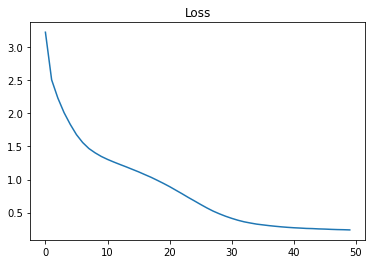

<function matplotlib.pyplot.show>

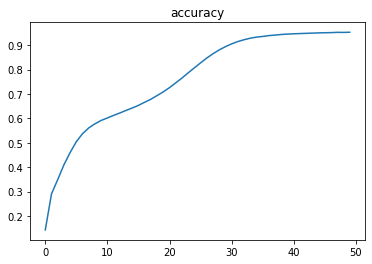

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.show

#Generate Text

In [18]:
model = build_model(vocab_size,
                      embedding_dim,
                      batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))


def generate(model, seed_text):
  '''Takes in model and outputs generated text based off of the seed text'''

  next_word = 500
  input_eval = [char2idx[i] for i in seed_text]
  input_eval = tf.expand_dims(input_eval, axis=0)

  generated_text = []

  temp = 1. #Changes the volatility of the text

  model.reset_states()

  for i in range(next_word):
    predictions = model(input_eval)

    predictions = tf.squeeze(predictions, 0)

    pred = predictions / temp

    pred_id = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()

    input_eval = tf.expand_dims([pred_id], 0)

    generated_text.append(idx2char[pred_id])

  return (seed_text + ''.join(generated_text))


seed = 'the inevitability'

generated_text = generate(model, seed)
print(generated_text)

the inevitability and obtrusive; he been for the foolished itself into the position
of both, he needs are among the f
